In [1]:
# CT数值预处理 - 前景z-score归一化
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path

# 设置matplotlib字体为英文
plt.rcParams['font.family'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['axes.unicode_minus'] = False

print("=== CT数值预处理 - 前景z-score归一化 ===")
print("目标：基于lung mask提取前景，进行强度裁剪和z-score归一化")

# 设置数据路径
data_dir = "cropped_roi_96x64x128"
output_dir = "ct_value_processed"
os.makedirs(output_dir, exist_ok=True)

print(f"输入数据目录: {os.path.abspath(data_dir)}")
print(f"输出目录: {os.path.abspath(output_dir)}")
print(f"目标ROI尺寸: [96, 64, 128]")

=== CT数值预处理 - 前景z-score归一化 ===
目标：基于lung mask提取前景，进行强度裁剪和z-score归一化
输入数据目录: /home/yaobo/Project/Lung_Cancer_Subtyping/cropped_roi_96x64x128
输出目录: /home/yaobo/Project/Lung_Cancer_Subtyping/ct_value_processed
目标ROI尺寸: [96, 64, 128]


In [2]:
# 步骤1: 统计所有病例的前景HU值分布
def collect_foreground_hu_values():
    """
    收集所有病例的前景HU值（基于lung mask）
    """
    print("=== 收集所有病例的前景HU值 ===")
    
    all_hu_values = []
    processed_count = 0
    failed_cases = []
    
    # 遍历所有中心和病例
    for center_dir in os.listdir(data_dir):
        center_path = os.path.join(data_dir, center_dir)
        if not os.path.isdir(center_path):
            continue
            
        print(f"处理中心: {center_dir}")
        
        for case_dir in tqdm(os.listdir(center_path), desc=f"处理{center_dir}"):
            case_path = os.path.join(center_path, case_dir)
            if not os.path.isdir(case_path):
                continue
                
            try:
                # 加载CT和lung mask
                ct_path = os.path.join(case_path, "CT.nii.gz")
                lung_mask_path = os.path.join(case_path, "lung_mask.nii.gz")
                
                if not (os.path.exists(ct_path) and os.path.exists(lung_mask_path)):
                    print(f"缺少文件: {center_dir}/{case_dir}")
                    failed_cases.append(f"{center_dir}/{case_dir} - 缺少文件")
                    continue
                
                # 加载数据
                ct_nii = nib.load(ct_path)
                ct_data = ct_nii.get_fdata()
                
                lung_nii = nib.load(lung_mask_path)
                lung_mask = lung_nii.get_fdata()
                
                # 验证尺寸
                if ct_data.shape != (96, 64, 128) or lung_mask.shape != (96, 64, 128):
                    print(f"尺寸不匹配: {center_dir}/{case_dir} - CT:{ct_data.shape}, Lung:{lung_mask.shape}")
                    failed_cases.append(f"{center_dir}/{case_dir} - 尺寸不匹配")
                    continue
                
                # 提取前景HU值（lung mask > 0的区域）
                foreground_mask = lung_mask > 0
                foreground_hu = ct_data[foreground_mask]
                
                if len(foreground_hu) == 0:
                    print(f"空前景: {center_dir}/{case_dir}")
                    failed_cases.append(f"{center_dir}/{case_dir} - 空前景")
                    continue
                
                # 添加到总体HU值列表
                all_hu_values.extend(foreground_hu.flatten())
                processed_count += 1
                
                # 每100个样本显示一次进度
                if processed_count % 100 == 0:
                    print(f"已处理: {processed_count} 个样本，累计前景体素: {len(all_hu_values):,}")
                
            except Exception as e:
                print(f"处理失败: {center_dir}/{case_dir} - 错误: {e}")
                failed_cases.append(f"{center_dir}/{case_dir} - {str(e)}")
    
    print(f"\n=== 收集完成 ===")
    print(f"成功处理: {processed_count} 个样本")
    print(f"处理失败: {len(failed_cases)} 个样本")
    print(f"总前景体素数: {len(all_hu_values):,}")
    
    if failed_cases:
        print("\n失败案例:")
        for case in failed_cases[:10]:  # 只显示前10个
            print(f"- {case}")
        if len(failed_cases) > 10:
            print(f"... 还有 {len(failed_cases)-10} 个失败案例")
    
    return np.array(all_hu_values), processed_count, failed_cases

# 执行收集前景HU值
print("开始收集所有病例的前景HU值...")
all_foreground_hu, success_count, failed_list = collect_foreground_hu_values()

开始收集所有病例的前景HU值...
=== 收集所有病例的前景HU值 ===
处理中心: Neimeng_nifti_425


处理Neimeng_nifti_425:  25%|██▌       | 103/412 [00:06<00:16, 18.50it/s]

已处理: 100 个样本，累计前景体素: 7,071,387


处理Neimeng_nifti_425:  49%|████▉     | 201/412 [00:11<00:10, 19.59it/s]

已处理: 200 个样本，累计前景体素: 14,087,084


处理Neimeng_nifti_425:  73%|███████▎  | 302/412 [00:16<00:05, 19.35it/s]

已处理: 300 个样本，累计前景体素: 20,809,333


处理Neimeng_nifti_425:  98%|█████████▊| 403/412 [00:21<00:00, 17.85it/s]

已处理: 400 个样本，累计前景体素: 27,743,026


处理Neimeng_nifti_425: 100%|██████████| 412/412 [00:22<00:00, 18.36it/s]


处理中心: AKH_nifti_637


处理AKH_nifti_637:  15%|█▍        | 91/618 [00:04<00:28, 18.54it/s]

已处理: 500 个样本，累计前景体素: 35,169,597


处理AKH_nifti_637:  31%|███       | 192/618 [00:10<00:21, 19.50it/s]

已处理: 600 个样本，累计前景体素: 42,342,091


处理AKH_nifti_637:  47%|████▋     | 291/618 [00:15<00:18, 18.16it/s]

已处理: 700 个样本，累计前景体素: 49,498,967


处理AKH_nifti_637:  63%|██████▎   | 391/618 [00:20<00:12, 18.76it/s]

已处理: 800 个样本，累计前景体素: 57,049,901


处理AKH_nifti_637:  79%|███████▉  | 491/618 [00:26<00:06, 18.51it/s]

已处理: 900 个样本，累计前景体素: 64,026,317


处理AKH_nifti_637:  96%|█████████▌| 591/618 [00:31<00:01, 18.00it/s]

已处理: 1000 个样本，累计前景体素: 71,597,720


处理AKH_nifti_637: 100%|██████████| 618/618 [00:33<00:00, 18.55it/s]


=== 收集完成 ===
成功处理: 1030 个样本
处理失败: 0 个样本
总前景体素数: 73,713,039


开始分析前景HU值分布...
=== 分析前景HU值分布 ===


HU值统计信息:
- 总体素数: 73,713,039
- 最小值: -1024.0
- 最大值: 2626.3
- 均值: -721.86
- 标准差: 185.76
- 中位数: -779.35
- 1%分位数: -946.86
- 99%分位数: 2.81
- 0.5%分位数: -962.17 ← 下界clip值
- 99.5%分位数: 25.89 ← 上界clip值


/tmp/ipykernel_760054/2920816311.py:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(box_data, patch_artist=True, labels=['Foreground HU'])
/tmp/ipykernel_760054/2920816311.py:99: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_760054/2920816311.py:103: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(fig_path, dpi=300, bbox_inches='tight')



图形已保存: ct_value_processed/foreground_hu_distribution.png


/home/yaobo/miniconda3/envs/lungcancer/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


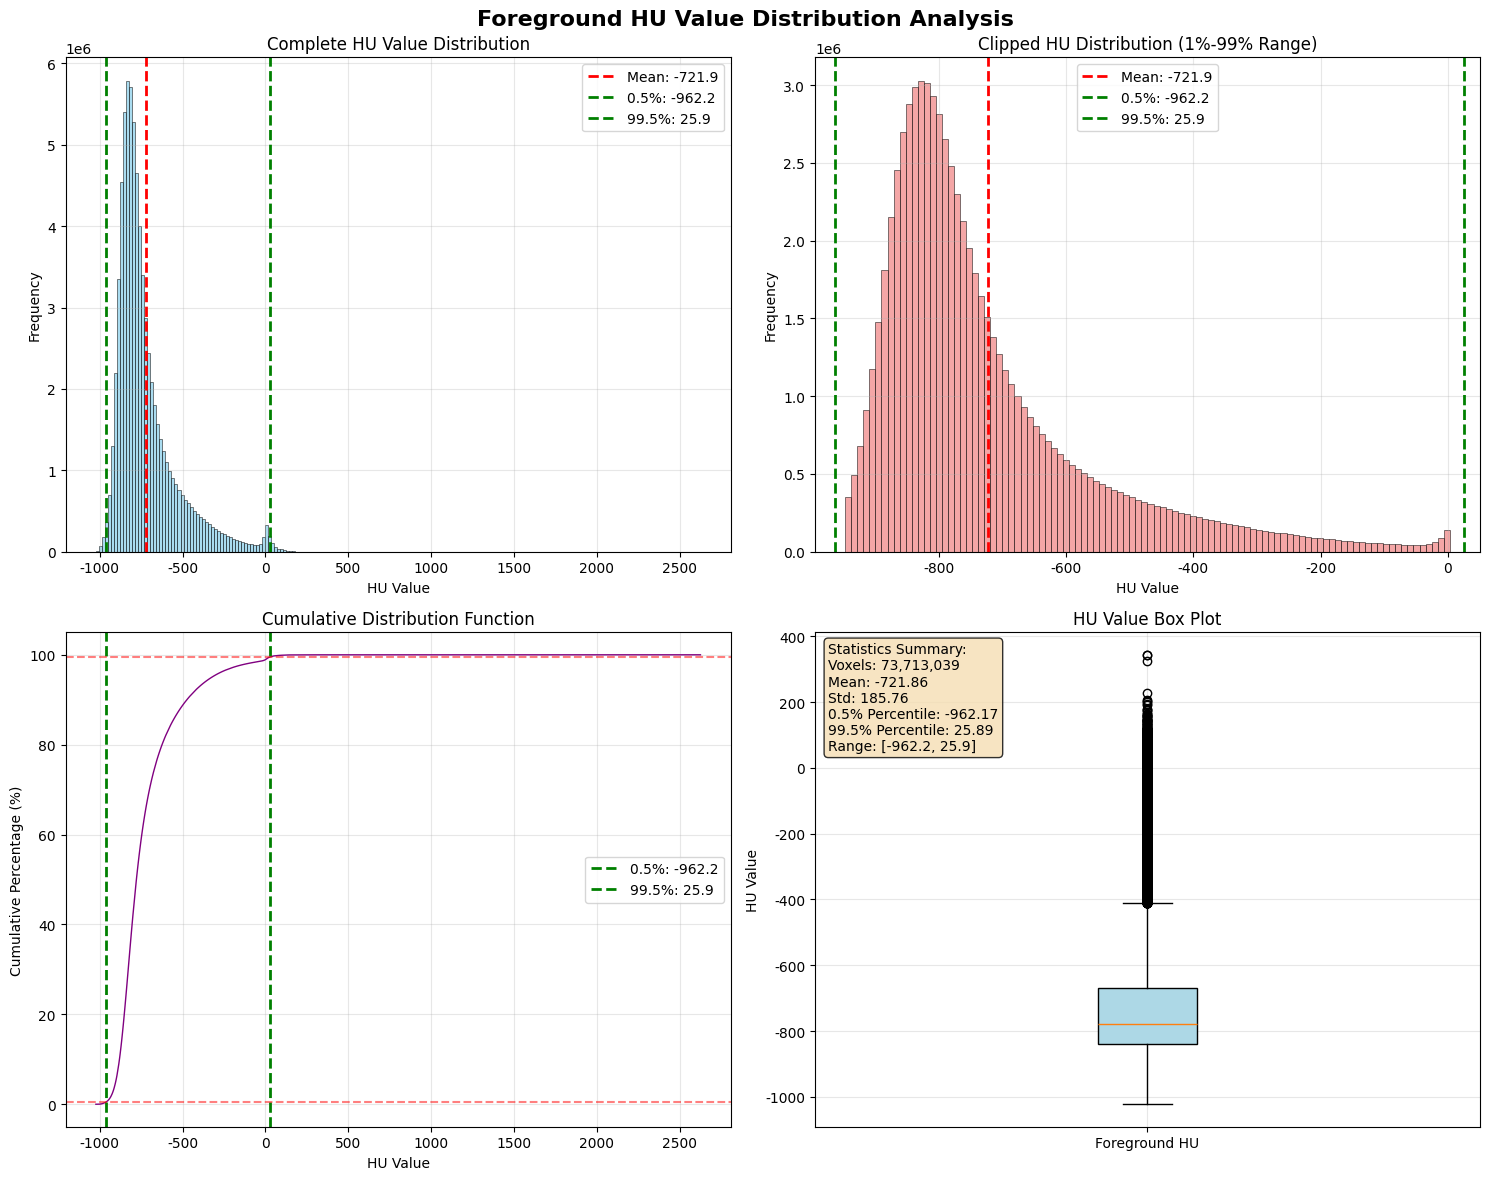

统计结果已保存:
- CSV文件: ct_value_processed/hu_statistics.csv
- 详细报告: ct_value_processed/hu_statistics_report.txt


In [8]:
# 步骤2: 分析HU值分布并计算统计指标
def analyze_hu_distribution(hu_values):
    """
    分析HU值分布，计算关键统计指标，绘制直方图
    """
    print("=== 分析前景HU值分布 ===")
    
    # 计算统计指标
    mean_hu = np.mean(hu_values)
    std_hu = np.std(hu_values)
    p0_5 = np.percentile(hu_values, 0.5)   # 0.5百分位数
    p99_5 = np.percentile(hu_values, 99.5) # 99.5百分位数
    
    # 其他统计信息
    min_hu = np.min(hu_values)
    max_hu = np.max(hu_values)
    median_hu = np.median(hu_values)
    p1 = np.percentile(hu_values, 1)
    p99 = np.percentile(hu_values, 99)
    
    print(f"HU值统计信息:")
    print(f"- 总体素数: {len(hu_values):,}")
    print(f"- 最小值: {min_hu:.1f}")
    print(f"- 最大值: {max_hu:.1f}")
    print(f"- 均值: {mean_hu:.2f}")
    print(f"- 标准差: {std_hu:.2f}")
    print(f"- 中位数: {median_hu:.2f}")
    print(f"- 1%分位数: {p1:.2f}")
    print(f"- 99%分位数: {p99:.2f}")
    print(f"- 0.5%分位数: {p0_5:.2f} ← 下界clip值")
    print(f"- 99.5%分位数: {p99_5:.2f} ← 上界clip值")
    
    # 创建图形
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Foreground HU Value Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 子图1: 完整直方图
    axes[0, 0].hist(hu_values, bins=200, alpha=0.7, color='skyblue', edgecolor='black', linewidth=0.5)
    axes[0, 0].axvline(mean_hu, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_hu:.1f}')
    axes[0, 0].axvline(p0_5, color='green', linestyle='--', linewidth=2, label=f'0.5%: {p0_5:.1f}')
    axes[0, 0].axvline(p99_5, color='green', linestyle='--', linewidth=2, label=f'99.5%: {p99_5:.1f}')
    axes[0, 0].set_title('Complete HU Value Distribution')
    axes[0, 0].set_xlabel('HU Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 子图2: 裁剪后的直方图（去除极值）
    clipped_range = (p1, p99)
    mask = (hu_values >= clipped_range[0]) & (hu_values <= clipped_range[1])
    hu_clipped = hu_values[mask]
    
    axes[0, 1].hist(hu_clipped, bins=100, alpha=0.7, color='lightcoral', edgecolor='black', linewidth=0.5)
    axes[0, 1].axvline(mean_hu, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_hu:.1f}')
    axes[0, 1].axvline(p0_5, color='green', linestyle='--', linewidth=2, label=f'0.5%: {p0_5:.1f}')
    axes[0, 1].axvline(p99_5, color='green', linestyle='--', linewidth=2, label=f'99.5%: {p99_5:.1f}')
    axes[0, 1].set_title(f'Clipped HU Distribution (1%-99% Range)')
    axes[0, 1].set_xlabel('HU Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 子图3: 累积分布函数
    sorted_hu = np.sort(hu_values)
    cum_prob = np.arange(1, len(sorted_hu) + 1) / len(sorted_hu)
    
    axes[1, 0].plot(sorted_hu, cum_prob * 100, color='purple', linewidth=1)
    axes[1, 0].axvline(p0_5, color='green', linestyle='--', linewidth=2, label=f'0.5%: {p0_5:.1f}')
    axes[1, 0].axvline(p99_5, color='green', linestyle='--', linewidth=2, label=f'99.5%: {p99_5:.1f}')
    axes[1, 0].axhline(0.5, color='red', linestyle='--', alpha=0.5)
    axes[1, 0].axhline(99.5, color='red', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Cumulative Distribution Function')
    axes[1, 0].set_xlabel('HU Value')
    axes[1, 0].set_ylabel('Cumulative Percentage (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 子图4: 箱型图
    box_data = [hu_values[::1000]]  # 采样以提高绘制速度
    bp = axes[1, 1].boxplot(box_data, patch_artist=True, labels=['Foreground HU'])
    bp['boxes'][0].set_facecolor('lightblue')
    axes[1, 1].set_title('HU Value Box Plot')
    axes[1, 1].set_ylabel('HU Value')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 添加统计信息文本
    stats_text = f'''Statistics Summary:
Voxels: {len(hu_values):,}
Mean: {mean_hu:.2f}
Std: {std_hu:.2f}
0.5% Percentile: {p0_5:.2f}
99.5% Percentile: {p99_5:.2f}
Range: [{p0_5:.1f}, {p99_5:.1f}]'''
    
    axes[1, 1].text(0.02, 0.98, stats_text, transform=axes[1, 1].transAxes, 
                    verticalalignment='top', fontsize=10, 
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    
    # 保存图形
    fig_path = os.path.join(output_dir, "foreground_hu_distribution.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\n图形已保存: {fig_path}")
    
    plt.show()
    
    # 保存统计结果
    stats_dict = {
        'total_voxels': len(hu_values),
        'mean': mean_hu,
        'std': std_hu,
        'min': min_hu,
        'max': max_hu,
        'median': median_hu,
        'p0_5': p0_5,
        'p99_5': p99_5,
        'p1': p1,
        'p99': p99,
        'clip_range': [p0_5, p99_5],
        'normalization_params': {'mean': mean_hu, 'std': std_hu}
    }
    
    # 保存到CSV文件
    stats_df = pd.DataFrame([stats_dict])
    stats_path = os.path.join(output_dir, "hu_statistics.csv")
    stats_df.to_csv(stats_path, index=False)
    
    # 保存详细统计报告
    report_content = f"""前景HU值分布统计报告
=======================

数据概览:
- 分析时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
- 样本数量: {success_count} 个病例
- 总体素数: {len(hu_values):,} 个前景体素
- 数据来源: cropped_roi_96x64x128

基础统计:
- 最小值: {min_hu:.2f} HU
- 最大值: {max_hu:.2f} HU
- 均值: {mean_hu:.2f} HU
- 标准差: {std_hu:.2f} HU
- 中位数: {median_hu:.2f} HU

百分位数统计:
- 0.5%分位数: {p0_5:.2f} HU ← 下界clip值
- 1%分位数: {p1:.2f} HU
- 99%分位数: {p99:.2f} HU
- 99.5%分位数: {p99_5:.2f} HU ← 上界clip值

预处理参数:
================
1. 强度裁剪 (Clipping):
   - 下界: {p0_5:.2f} HU
   - 上界: {p99_5:.2f} HU
   - 公式: clipped_hu = np.clip(original_hu, {p0_5:.2f}, {p99_5:.2f})

2. Z-score归一化:
   - 均值: {mean_hu:.2f} HU
   - 标准差: {std_hu:.2f} HU
   - 公式: normalized_hu = (clipped_hu - {mean_hu:.2f}) / {std_hu:.2f}

质量评估:
- 异常值比例 (<0.5%): {(hu_values < p0_5).sum() / len(hu_values) * 100:.3f}%
- 异常值比例 (>99.5%): {(hu_values > p99_5).sum() / len(hu_values) * 100:.3f}%
- 有效范围覆盖: {((hu_values >= p0_5) & (hu_values <= p99_5)).sum() / len(hu_values) * 100:.1f}%

文件输出:
- 统计图表: foreground_hu_distribution.png
- 统计数据: hu_statistics.csv
- 详细报告: hu_statistics_report.txt
"""
    
    report_path = os.path.join(output_dir, "hu_statistics_report.txt")
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(report_content)
    
    print(f"统计结果已保存:")
    print(f"- CSV文件: {stats_path}")
    print(f"- 详细报告: {report_path}")
    
    return stats_dict

# 执行HU值分布分析
print("开始分析前景HU值分布...")
hu_stats = analyze_hu_distribution(all_foreground_hu)

In [5]:
# 步骤3: 对每个CT进行预处理（clip + z-score归一化）
def preprocess_all_ct_data(stats_dict):
    """
    对所有CT数据进行预处理：
    1. 基于0.5%和99.5%百分位数进行clip操作
    2. 基于均值和标准差进行z-score归一化
    """
    print("=== 对所有CT进行预处理 ===")
    
    # 获取预处理参数
    clip_min = stats_dict['p0_5']
    clip_max = stats_dict['p99_5']
    mean_hu = stats_dict['mean']
    std_hu = stats_dict['std']
    
    print(f"预处理参数:")
    print(f"- Clip范围: [{clip_min:.2f}, {clip_max:.2f}] HU")
    print(f"- Z-score参数: 均值={mean_hu:.2f}, 标准差={std_hu:.2f}")
    
    processed_count = 0
    failed_cases = []
    
    # 创建输出目录结构
    processed_dir = os.path.join(output_dir, "processed_ct")
    os.makedirs(processed_dir, exist_ok=True)
    
    # 遍历所有中心和病例
    for center_dir in os.listdir(data_dir):
        center_path = os.path.join(data_dir, center_dir)
        if not os.path.isdir(center_path):
            continue
            
        # 创建输出中心目录
        output_center_dir = os.path.join(processed_dir, center_dir)
        os.makedirs(output_center_dir, exist_ok=True)
        
        print(f"处理中心: {center_dir}")
        
        for case_dir in tqdm(os.listdir(center_path), desc=f"预处理{center_dir}"):
            case_path = os.path.join(center_path, case_dir)
            if not os.path.isdir(case_path):
                continue
                
            # 创建输出案例目录
            output_case_dir = os.path.join(output_center_dir, case_dir)
            os.makedirs(output_case_dir, exist_ok=True)
            
            try:
                # 加载原始CT数据
                ct_path = os.path.join(case_path, "CT.nii.gz")
                lung_mask_path = os.path.join(case_path, "lung_mask.nii.gz")
                
                if not os.path.exists(ct_path):
                    failed_cases.append(f"{center_dir}/{case_dir} - 缺少CT文件")
                    continue
                
                # 加载CT数据
                ct_nii = nib.load(ct_path)
                ct_data = ct_nii.get_fdata().copy()
                
                # 记录原始统计信息
                original_min = np.min(ct_data)
                original_max = np.max(ct_data)
                original_mean = np.mean(ct_data)
                
                # 步骤1: Clip操作
                ct_clipped = np.clip(ct_data, clip_min, clip_max)
                
                # 步骤2: Z-score归一化
                ct_normalized = (ct_clipped - mean_hu) / std_hu
                
                # 记录处理后统计信息
                norm_min = np.min(ct_normalized)
                norm_max = np.max(ct_normalized)
                norm_mean = np.mean(ct_normalized)
                norm_std = np.std(ct_normalized)
                
                # 计算前景区域的统计信息（如果有lung mask）
                foreground_stats = "N/A"
                if os.path.exists(lung_mask_path):
                    lung_nii = nib.load(lung_mask_path)
                    lung_mask = lung_nii.get_fdata()
                    foreground_mask = lung_mask > 0
                    
                    if np.any(foreground_mask):
                        fg_original = ct_data[foreground_mask]
                        fg_normalized = ct_normalized[foreground_mask]
                        
                        foreground_stats = f"""前景统计 (基于lung mask):
原始: min={np.min(fg_original):.1f}, max={np.max(fg_original):.1f}, mean={np.mean(fg_original):.1f}
归一化: min={np.min(fg_normalized):.2f}, max={np.max(fg_normalized):.2f}, mean={np.mean(fg_normalized):.2f}, std={np.std(fg_normalized):.2f}"""
                
                # 保存处理后的CT数据
                ct_processed_nii = nib.Nifti1Image(ct_normalized.astype(np.float32), ct_nii.affine, ct_nii.header)
                output_ct_path = os.path.join(output_case_dir, "CT_processed.nii.gz")
                nib.save(ct_processed_nii, output_ct_path)
                
                # 复制其他文件（PET, lung_mask, lesion_mask）
                for filename in ["PET.nii.gz", "lung_mask.nii.gz", "lesion_mask.nii.gz"]:
                    src_path = os.path.join(case_path, filename)
                    if os.path.exists(src_path):
                        dst_path = os.path.join(output_case_dir, filename)
                        nii = nib.load(src_path)
                        nib.save(nii, dst_path)
                
                # 创建处理信息文件
                process_info = f"""CT预处理信息
================

案例信息:
- 中心: {center_dir}
- PID: {case_dir}
- 处理时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

预处理参数:
- Clip下界: {clip_min:.2f} HU
- Clip上界: {clip_max:.2f} HU
- 归一化均值: {mean_hu:.2f} HU
- 归一化标准差: {std_hu:.2f} HU

处理步骤:
1. 强度裁剪: clipped = np.clip(original, {clip_min:.2f}, {clip_max:.2f})
2. Z-score归一化: normalized = (clipped - {mean_hu:.2f}) / {std_hu:.2f}

统计对比:
原始数据: min={original_min:.1f}, max={original_max:.1f}, mean={original_mean:.1f}
处理后: min={norm_min:.2f}, max={norm_max:.2f}, mean={norm_mean:.2f}, std={norm_std:.2f}

{foreground_stats}

输出文件:
- CT_processed.nii.gz: 预处理后的CT数据 (Float32)
- PET.nii.gz: 原始PET数据 (复制)
- lung_mask.nii.gz: lung mask (复制)
- lesion_mask.nii.gz: lesion mask (复制)
"""
                
                info_path = os.path.join(output_case_dir, "preprocessing_info.txt")
                with open(info_path, 'w', encoding='utf-8') as f:
                    f.write(process_info)
                
                processed_count += 1
                
                # 每100个样本显示一次进度
                if processed_count % 100 == 0:
                    print(f"✓ 已预处理: {processed_count} 个样本")
                
            except Exception as e:
                print(f"\n❌ 预处理失败: {center_dir}/{case_dir} - 错误: {e}")
                failed_cases.append(f"{center_dir}/{case_dir} - {str(e)}")
    
    # 创建总体处理摘要
    summary_content = f"""CT预处理总结
===============

处理时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
输出目录: {os.path.abspath(processed_dir)}

预处理参数:
- Clip范围: [{clip_min:.2f}, {clip_max:.2f}] HU
- Z-score均值: {mean_hu:.2f} HU
- Z-score标准差: {std_hu:.2f} HU

处理结果:
- 总样本数: {processed_count + len(failed_cases)}
- 成功处理: {processed_count}
- 处理失败: {len(failed_cases)}
- 成功率: {processed_count/(processed_count + len(failed_cases))*100:.1f}%

处理流程:
1. 读取原始CT数据
2. 强度裁剪: 将HU值限制在 [{clip_min:.2f}, {clip_max:.2f}] 范围内
3. Z-score归一化: (clipped_hu - {mean_hu:.2f}) / {std_hu:.2f}
4. 保存为Float32格式
5. 复制其他模态数据

文件结构:
{processed_dir}/
├── center1/
│   ├── case1/
│   │   ├── CT_processed.nii.gz    # 预处理后的CT
│   │   ├── PET.nii.gz             # 原始PET
│   │   ├── lung_mask.nii.gz       # lung mask
│   │   ├── lesion_mask.nii.gz     # lesion mask
│   │   └── preprocessing_info.txt  # 处理信息
│   └── ...
└── ...

深度学习使用:
- 输入数据: CT_processed.nii.gz (已归一化)
- 数据类型: Float32
- 值域: 大约 [-5, 5] (z-score归一化后)
- 可直接用于模型训练，无需额外归一化
"""
    
    if failed_cases:
        summary_content += f"\n处理失败的案例:\n"
        for i, case in enumerate(failed_cases[:20]):
            summary_content += f"- {case}\n"
        if len(failed_cases) > 20:
            summary_content += f"... 还有 {len(failed_cases)-20} 个失败案例\n"
    
    summary_path = os.path.join(output_dir, "ct_preprocessing_summary.txt")
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write(summary_content)
    
    print(f"\n=== 预处理完成 ===")
    print(f"成功处理: {processed_count} 个样本")
    print(f"输出目录: {os.path.abspath(processed_dir)}")
    print(f"处理摘要: {summary_path}")
    
    if failed_cases:
        print(f"处理失败: {len(failed_cases)} 个案例")
        print("详细信息请查看摘要文件")
    
    return processed_count, failed_cases, processed_dir

# 执行CT预处理
print("开始对所有CT进行预处理...")
processed_count, failed_list, processed_output_dir = preprocess_all_ct_data(hu_stats)

开始对所有CT进行预处理...
=== 对所有CT进行预处理 ===
预处理参数:
- Clip范围: [-962.17, 25.89] HU
- Z-score参数: 均值=-721.86, 标准差=185.76
处理中心: Neimeng_nifti_425


预处理Neimeng_nifti_425:   0%|          | 0/412 [00:00<?, ?it/s]

预处理Neimeng_nifti_425:  24%|██▍       | 100/412 [00:39<02:00,  2.58it/s]

✓ 已预处理: 100 个样本


预处理Neimeng_nifti_425:  49%|████▊     | 200/412 [01:17<01:22,  2.58it/s]

✓ 已预处理: 200 个样本


预处理Neimeng_nifti_425:  73%|███████▎  | 300/412 [01:55<00:42,  2.66it/s]

✓ 已预处理: 300 个样本


预处理Neimeng_nifti_425:  97%|█████████▋| 400/412 [02:34<00:04,  2.58it/s]

✓ 已预处理: 400 个样本


预处理Neimeng_nifti_425: 100%|██████████| 412/412 [02:38<00:00,  2.59it/s]


处理中心: AKH_nifti_637


预处理AKH_nifti_637:  14%|█▍        | 88/618 [00:25<02:43,  3.24it/s]

✓ 已预处理: 500 个样本


预处理AKH_nifti_637:  30%|███       | 188/618 [00:53<01:52,  3.83it/s]

✓ 已预处理: 600 个样本


预处理AKH_nifti_637:  47%|████▋     | 288/618 [01:23<01:27,  3.79it/s]

✓ 已预处理: 700 个样本


预处理AKH_nifti_637:  63%|██████▎   | 388/618 [01:52<01:03,  3.62it/s]

✓ 已预处理: 800 个样本


预处理AKH_nifti_637:  79%|███████▉  | 488/618 [02:20<00:33,  3.88it/s]

✓ 已预处理: 900 个样本


预处理AKH_nifti_637:  95%|█████████▌| 588/618 [02:48<00:07,  4.04it/s]

✓ 已预处理: 1000 个样本


预处理AKH_nifti_637: 100%|██████████| 618/618 [02:57<00:00,  3.49it/s]


=== 预处理完成 ===
成功处理: 1030 个样本
输出目录: /home/yaobo/Project/Lung_Cancer_Subtyping/ct_value_processed/processed_ct
处理摘要: ct_value_processed/ct_preprocessing_summary.txt


开始验证预处理结果...
=== 验证预处理结果 ===
验证样本: [('Neimeng_nifti_425', '214'), ('Neimeng_nifti_425', '381'), ('Neimeng_nifti_425', '239'), ('Neimeng_nifti_425', '338'), ('Neimeng_nifti_425', '349')]
样本 1: Neimeng_nifti_425/214
  原始前景: min=-996.0, max=358.0, mean=-700.4
  处理前景: min=-1.29, max=4.03, mean=0.12, std=0.95
样本 2: Neimeng_nifti_425/381
  原始前景: min=-996.8, max=351.8, mean=-748.4
  处理前景: min=-1.29, max=4.03, mean=-0.14, std=0.87


样本 3: Neimeng_nifti_425/239
  原始前景: min=-1022.9, max=875.8, mean=-771.9
  处理前景: min=-1.29, max=4.03, mean=-0.27, std=0.90
样本 4: Neimeng_nifti_425/338
  原始前景: min=-979.0, max=280.6, mean=-607.2
  处理前景: min=-1.29, max=4.03, mean=0.62, std=1.73
样本 5: Neimeng_nifti_425/349
  原始前景: min=-1001.1, max=310.4, mean=-711.6
  处理前景: min=-1.29, max=4.03, mean=0.05, std=0.97

验证图形已保存: ct_value_processed/preprocessing_validation.png


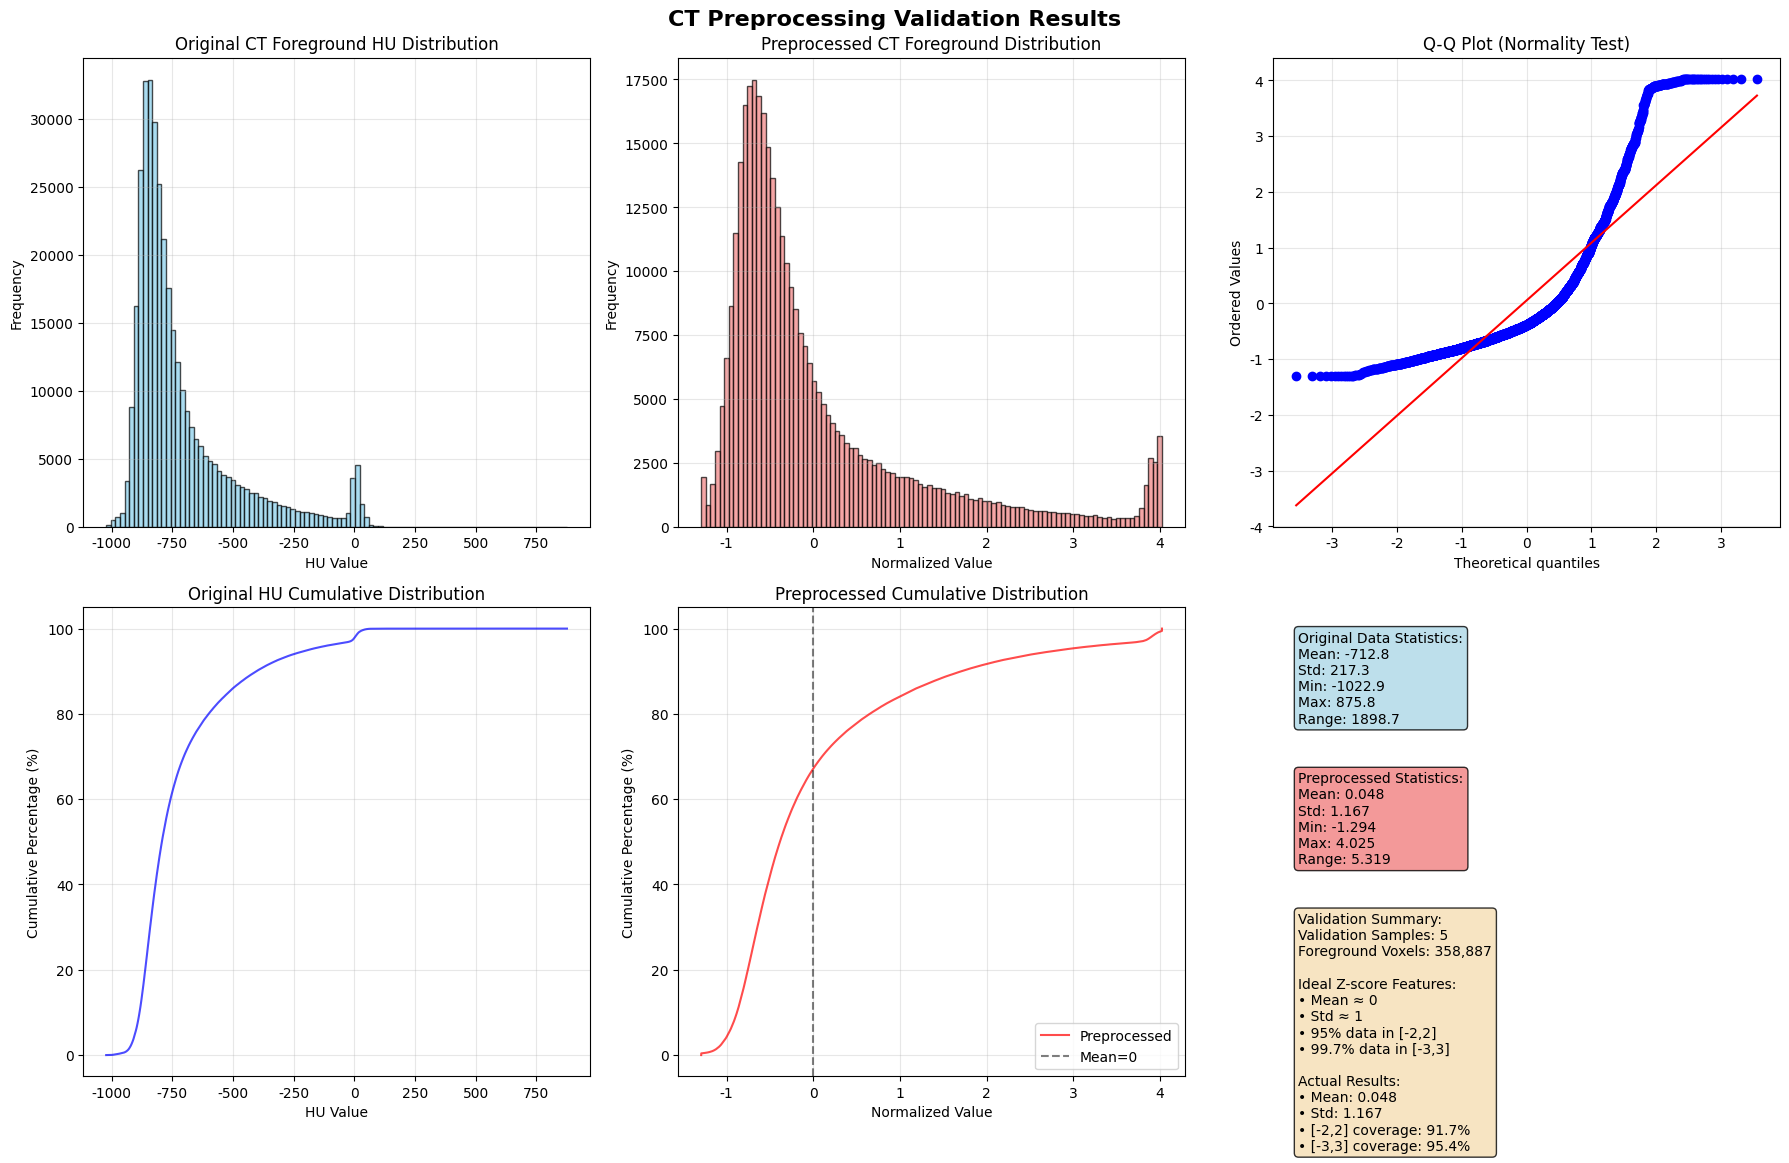

验证报告已保存: ct_value_processed/preprocessing_validation_report.txt

=== 验证结果 ===
均值接近0: ✓ (0.0484)
标准差接近1: ✗ (1.1672)
整体评估: ⚠ 需要检查


In [7]:
# 步骤4: 验证预处理结果
def validate_preprocessing_results():
    """
    验证预处理结果：
    1. 检查几个样本的归一化效果
    2. 对比原始和处理后的数据分布
    3. 验证前景区域的z-score分布
    """
    print("=== 验证预处理结果 ===")
    
    processed_dir = os.path.join(output_dir, "processed_ct")
    
    # 随机选择几个样本进行验证
    validation_samples = []
    sample_count = 0
    
    for center_dir in os.listdir(processed_dir):
        center_path = os.path.join(processed_dir, center_dir)
        if not os.path.isdir(center_path):
            continue
            
        for case_dir in os.listdir(center_path):
            if sample_count >= 5:  # 验证5个样本
                break
            case_path = os.path.join(center_path, case_dir)
            if os.path.isdir(case_path):
                validation_samples.append((center_dir, case_dir))
                sample_count += 1
        
        if sample_count >= 5:
            break
    
    print(f"验证样本: {validation_samples}")
    
    # 创建验证图形
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('CT Preprocessing Validation Results', fontsize=16, fontweight='bold')
    
    all_original_fg = []
    all_processed_fg = []
    
    # 验证每个样本
    for i, (center, case) in enumerate(validation_samples):
        try:
            # 加载原始和处理后的数据
            original_ct_path = os.path.join(data_dir, center, case, "CT.nii.gz")
            processed_ct_path = os.path.join(processed_dir, center, case, "CT_processed.nii.gz")
            lung_mask_path = os.path.join(processed_dir, center, case, "lung_mask.nii.gz")
            
            original_ct = nib.load(original_ct_path).get_fdata()
            processed_ct = nib.load(processed_ct_path).get_fdata()
            lung_mask = nib.load(lung_mask_path).get_fdata()
            
            # 提取前景区域
            foreground_mask = lung_mask > 0
            original_fg = original_ct[foreground_mask]
            processed_fg = processed_ct[foreground_mask]
            
            all_original_fg.extend(original_fg.flatten())
            all_processed_fg.extend(processed_fg.flatten())
            
            print(f"样本 {i+1}: {center}/{case}")
            print(f"  原始前景: min={np.min(original_fg):.1f}, max={np.max(original_fg):.1f}, mean={np.mean(original_fg):.1f}")
            print(f"  处理前景: min={np.min(processed_fg):.2f}, max={np.max(processed_fg):.2f}, mean={np.mean(processed_fg):.2f}, std={np.std(processed_fg):.2f}")
            
        except Exception as e:
            print(f"验证失败: {center}/{case} - {e}")
    
    # 绘制对比图
    all_original_fg = np.array(all_original_fg)
    all_processed_fg = np.array(all_processed_fg)
    
    # 子图1: 原始HU值分布
    axes[0, 0].hist(all_original_fg, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Original CT Foreground HU Distribution')
    axes[0, 0].set_xlabel('HU Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 子图2: 处理后分布
    axes[0, 1].hist(all_processed_fg, bins=100, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 1].set_title('Preprocessed CT Foreground Distribution')
    axes[0, 1].set_xlabel('Normalized Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 子图3: Q-Q plot检验正态性
    from scipy import stats
    stats.probplot(all_processed_fg[::100], dist="norm", plot=axes[0, 2])  # 采样以提高速度
    axes[0, 2].set_title('Q-Q Plot (Normality Test)')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 子图4: 累积分布对比
    sorted_original = np.sort(all_original_fg)
    sorted_processed = np.sort(all_processed_fg)
    cum_prob = np.arange(1, len(sorted_original) + 1) / len(sorted_original)
    
    axes[1, 0].plot(sorted_original, cum_prob * 100, label='Original', color='blue', alpha=0.7)
    axes[1, 0].set_title('Original HU Cumulative Distribution')
    axes[1, 0].set_xlabel('HU Value')
    axes[1, 0].set_ylabel('Cumulative Percentage (%)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 子图5: 处理后累积分布
    cum_prob_proc = np.arange(1, len(sorted_processed) + 1) / len(sorted_processed)
    axes[1, 1].plot(sorted_processed, cum_prob_proc * 100, label='Preprocessed', color='red', alpha=0.7)
    axes[1, 1].axvline(0, color='black', linestyle='--', alpha=0.5, label='Mean=0')
    axes[1, 1].set_title('Preprocessed Cumulative Distribution')
    axes[1, 1].set_xlabel('Normalized Value')
    axes[1, 1].set_ylabel('Cumulative Percentage (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 子图6: 统计摘要
    axes[1, 2].axis('off')
    
    # 计算验证统计
    original_stats = f'''Original Data Statistics:
Mean: {np.mean(all_original_fg):.1f}
Std: {np.std(all_original_fg):.1f}
Min: {np.min(all_original_fg):.1f}
Max: {np.max(all_original_fg):.1f}
Range: {np.max(all_original_fg) - np.min(all_original_fg):.1f}'''
    
    processed_stats = f'''Preprocessed Statistics:
Mean: {np.mean(all_processed_fg):.3f}
Std: {np.std(all_processed_fg):.3f}
Min: {np.min(all_processed_fg):.3f}
Max: {np.max(all_processed_fg):.3f}
Range: {np.max(all_processed_fg) - np.min(all_processed_fg):.3f}'''
    
    validation_summary = f'''Validation Summary:
Validation Samples: {len(validation_samples)}
Foreground Voxels: {len(all_processed_fg):,}

Ideal Z-score Features:
• Mean ≈ 0
• Std ≈ 1
• 95% data in [-2,2]
• 99.7% data in [-3,3]

Actual Results:
• Mean: {np.mean(all_processed_fg):.3f}
• Std: {np.std(all_processed_fg):.3f}
• [-2,2] coverage: {np.sum(np.abs(all_processed_fg) <= 2) / len(all_processed_fg) * 100:.1f}%
• [-3,3] coverage: {np.sum(np.abs(all_processed_fg) <= 3) / len(all_processed_fg) * 100:.1f}%'''
    
    axes[1, 2].text(0.05, 0.95, original_stats, transform=axes[1, 2].transAxes,
                    verticalalignment='top', fontsize=10, 
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    axes[1, 2].text(0.05, 0.65, processed_stats, transform=axes[1, 2].transAxes,
                    verticalalignment='top', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    axes[1, 2].text(0.05, 0.35, validation_summary, transform=axes[1, 2].transAxes,
                    verticalalignment='top', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    
    # 保存验证图形
    validation_fig_path = os.path.join(output_dir, "preprocessing_validation.png")
    plt.savefig(validation_fig_path, dpi=300, bbox_inches='tight')
    print(f"\n验证图形已保存: {validation_fig_path}")
    
    plt.show()
    
    # 保存验证报告
    validation_report = f"""CT预处理验证报告
==================

验证时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
验证样本: {len(validation_samples)} 个随机选择的案例
验证体素: {len(all_processed_fg):,} 个前景体素

验证目标:
1. 检验z-score归一化效果
2. 确认数据分布合理性
3. 验证clip操作效果

原始数据特征:
- 均值: {np.mean(all_original_fg):.2f} HU
- 标准差: {np.std(all_original_fg):.2f} HU  
- 范围: [{np.min(all_original_fg):.1f}, {np.max(all_original_fg):.1f}] HU

预处理后特征:
- 均值: {np.mean(all_processed_fg):.4f} (目标: ≈0)
- 标准差: {np.std(all_processed_fg):.4f} (目标: ≈1)
- 范围: [{np.min(all_processed_fg):.3f}, {np.max(all_processed_fg):.3f}]

分布验证:
- 68%数据在[-1,1]内: {np.sum(np.abs(all_processed_fg) <= 1) / len(all_processed_fg) * 100:.1f}% (理论: 68.3%)
- 95%数据在[-2,2]内: {np.sum(np.abs(all_processed_fg) <= 2) / len(all_processed_fg) * 100:.1f}% (理论: 95.4%)
- 99.7%数据在[-3,3]内: {np.sum(np.abs(all_processed_fg) <= 3) / len(all_processed_fg) * 100:.1f}% (理论: 99.7%)

质量评估:
{"✓ 通过" if abs(np.mean(all_processed_fg)) < 0.1 else "✗ 未通过"} 均值接近0 (|均值| < 0.1)
{"✓ 通过" if abs(np.std(all_processed_fg) - 1) < 0.1 else "✗ 未通过"} 标准差接近1 (|std-1| < 0.1)

结论:
{'✓ CT预处理成功！数据已正确归一化，可用于深度学习模型训练。' if abs(np.mean(all_processed_fg)) < 0.1 and abs(np.std(all_processed_fg) - 1) < 0.1 else '⚠ 预处理存在问题，建议检查参数设置。'}

验证样本详情:
"""
    
    for i, (center, case) in enumerate(validation_samples):
        validation_report += f"- 样本{i+1}: {center}/{case}\n"
    
    validation_report_path = os.path.join(output_dir, "preprocessing_validation_report.txt")
    with open(validation_report_path, 'w', encoding='utf-8') as f:
        f.write(validation_report)
    
    print(f"验证报告已保存: {validation_report_path}")
    
    # 返回验证结果
    mean_close_to_zero = abs(np.mean(all_processed_fg)) < 0.1
    std_close_to_one = abs(np.std(all_processed_fg) - 1) < 0.1
    
    print(f"\n=== 验证结果 ===")
    print(f"均值接近0: {'✓' if mean_close_to_zero else '✗'} ({np.mean(all_processed_fg):.4f})")
    print(f"标准差接近1: {'✓' if std_close_to_one else '✗'} ({np.std(all_processed_fg):.4f})")
    print(f"整体评估: {'✓ 预处理成功' if mean_close_to_zero and std_close_to_one else '⚠ 需要检查'}")
    
    return mean_close_to_zero and std_close_to_one

# 执行验证
print("开始验证预处理结果...")
validation_passed = validate_preprocessing_results()

# PET归一化

开始PET图像SUV值转换...
=== PET图像SUV值转换 ===
加载metadata: 1030 个样本

SUV_ratio统计信息:
- 有效值数量: 1030
- 缺失值数量: 0
- 最小值: 0.000199
- 最大值: 0.001048
- 均值: 0.000407
- 标准差: 0.000127

SUV ratio分析图已保存: ct_value_processed/suv_ratio_analysis.png


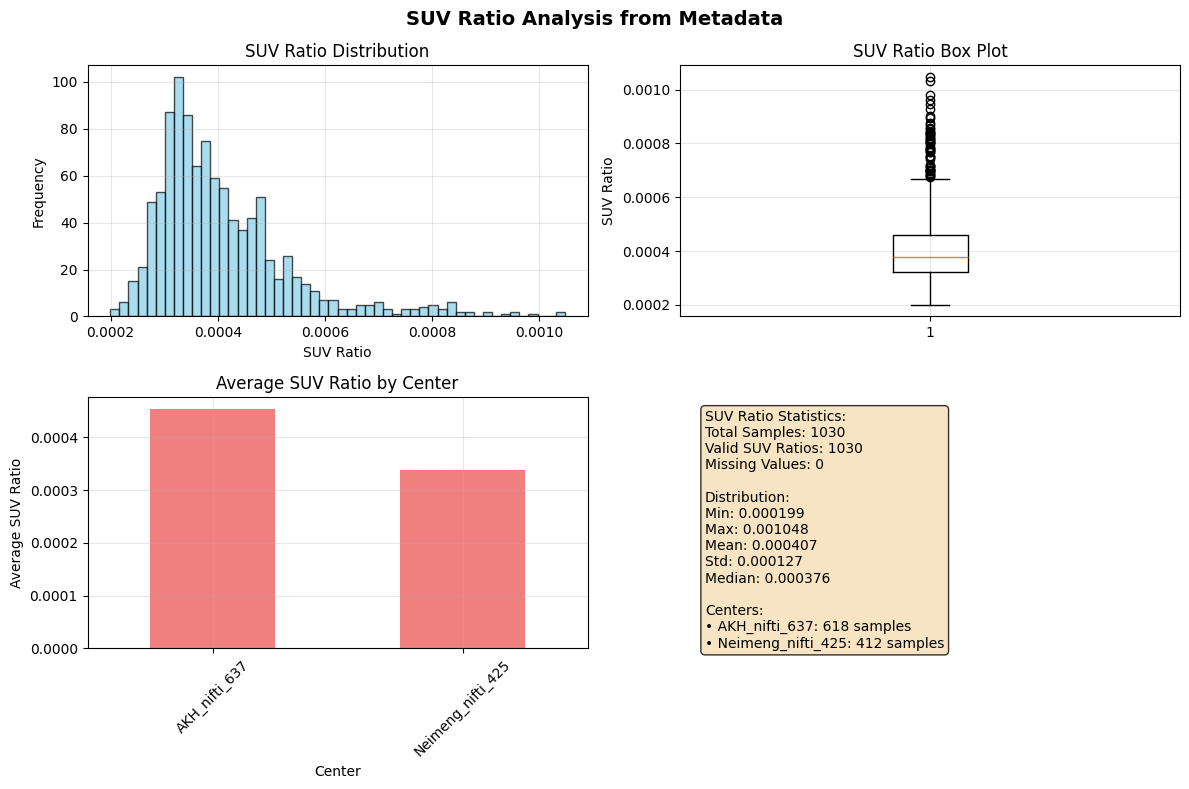

将处理 1030 个有效样本进行SUV转换

=== 开始PET SUV转换 ===


PET SUV转换:  10%|▉         | 100/1030 [00:24<03:36,  4.29it/s]

✓ 已转换: 100 个样本


PET SUV转换:  19%|█▉        | 200/1030 [00:48<03:16,  4.23it/s]

✓ 已转换: 200 个样本


PET SUV转换:  29%|██▉       | 300/1030 [01:12<02:47,  4.37it/s]

✓ 已转换: 300 个样本


PET SUV转换:  39%|███▉      | 400/1030 [01:37<03:00,  3.50it/s]

✓ 已转换: 400 个样本


PET SUV转换:  49%|████▊     | 500/1030 [02:00<01:59,  4.45it/s]

✓ 已转换: 500 个样本


PET SUV转换:  58%|█████▊    | 600/1030 [02:25<01:50,  3.88it/s]

✓ 已转换: 600 个样本


PET SUV转换:  68%|██████▊   | 700/1030 [02:53<01:32,  3.57it/s]

✓ 已转换: 700 个样本


PET SUV转换:  78%|███████▊  | 800/1030 [03:22<01:05,  3.50it/s]

✓ 已转换: 800 个样本


PET SUV转换:  87%|████████▋ | 900/1030 [03:50<00:37,  3.49it/s]

✓ 已转换: 900 个样本


PET SUV转换:  97%|█████████▋| 1000/1030 [04:19<00:08,  3.46it/s]

✓ 已转换: 1000 个样本


PET SUV转换: 100%|██████████| 1030/1030 [04:27<00:00,  3.85it/s]

转换统计数据已保存: ct_value_processed/suv_conversion_statistics.csv

=== SUV转换完成 ===
成功转换: 1030/1030 个样本 (100.0%)
输出目录: /home/yaobo/Project/Lung_Cancer_Subtyping/ct_value_processed/pet_suv_converted
转换摘要: ct_value_processed/pet_suv_conversion_summary.txt


In [9]:
# 步骤5: PET图像SUV值转换
def convert_pet_to_suv():
    """
    将PET图像转换为SUV值：
    1. 读取metadata中的SUV_ratio
    2. 对每个PET图像乘以对应的SUV_ratio
    3. 保存转换后的PET数据
    """
    print("=== PET图像SUV值转换 ===")
    
    # 读取metadata获取SUV ratio信息
    metadata_path = "metadata/metadata_filtered.csv"
    if not os.path.exists(metadata_path):
        print(f"错误: 找不到metadata文件: {metadata_path}")
        return None, None, None
    
    metadata_df = pd.read_csv(metadata_path, dtype={'PID': str})
    print(f"加载metadata: {len(metadata_df)} 个样本")
    
    # 检查SUV_ratio列是否存在
    if 'SUV_ratio' not in metadata_df.columns:
        print("错误: metadata中未找到SUV_ratio列")
        print(f"可用列: {list(metadata_df.columns)}")
        return None, None, None
    
    # 检查SUV_ratio的分布
    print(f"\nSUV_ratio统计信息:")
    print(f"- 有效值数量: {metadata_df['SUV_ratio'].notna().sum()}")
    print(f"- 缺失值数量: {metadata_df['SUV_ratio'].isna().sum()}")
    print(f"- 最小值: {metadata_df['SUV_ratio'].min():.6f}")
    print(f"- 最大值: {metadata_df['SUV_ratio'].max():.6f}")
    print(f"- 均值: {metadata_df['SUV_ratio'].mean():.6f}")
    print(f"- 标准差: {metadata_df['SUV_ratio'].std():.6f}")
    
    # 绘制SUV_ratio分布图
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.hist(metadata_df['SUV_ratio'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('SUV Ratio Distribution')
    plt.xlabel('SUV Ratio')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.boxplot(metadata_df['SUV_ratio'].dropna())
    plt.title('SUV Ratio Box Plot')
    plt.ylabel('SUV Ratio')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    center_suv = metadata_df.groupby('center')['SUV_ratio'].mean()
    center_suv.plot(kind='bar', color='lightcoral')
    plt.title('Average SUV Ratio by Center')
    plt.xlabel('Center')
    plt.ylabel('Average SUV Ratio')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    # 显示统计摘要
    plt.axis('off')
    stats_text = f'''SUV Ratio Statistics:
Total Samples: {len(metadata_df)}
Valid SUV Ratios: {metadata_df['SUV_ratio'].notna().sum()}
Missing Values: {metadata_df['SUV_ratio'].isna().sum()}

Distribution:
Min: {metadata_df['SUV_ratio'].min():.6f}
Max: {metadata_df['SUV_ratio'].max():.6f}
Mean: {metadata_df['SUV_ratio'].mean():.6f}
Std: {metadata_df['SUV_ratio'].std():.6f}
Median: {metadata_df['SUV_ratio'].median():.6f}

Centers:
{chr(10).join([f"• {center}: {count} samples" for center, count in metadata_df['center'].value_counts().items()])}'''
    
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
             verticalalignment='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.suptitle('SUV Ratio Analysis from Metadata', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # 保存SUV ratio分析图
    suv_analysis_path = os.path.join(output_dir, "suv_ratio_analysis.png")
    plt.savefig(suv_analysis_path, dpi=300, bbox_inches='tight')
    print(f"\nSUV ratio分析图已保存: {suv_analysis_path}")
    plt.show()
    
    # 处理缺失的SUV_ratio
    missing_suv = metadata_df['SUV_ratio'].isna().sum()
    if missing_suv > 0:
        print(f"\n警告: 发现 {missing_suv} 个样本缺少SUV_ratio，将跳过这些样本")
        valid_metadata = metadata_df.dropna(subset=['SUV_ratio']).copy()
    else:
        valid_metadata = metadata_df.copy()
    
    print(f"将处理 {len(valid_metadata)} 个有效样本进行SUV转换")
    
    # 创建SUV转换输出目录
    suv_output_dir = os.path.join(output_dir, "pet_suv_converted")
    os.makedirs(suv_output_dir, exist_ok=True)
    
    processed_count = 0
    failed_cases = []
    suv_conversion_stats = []
    
    print(f"\n=== 开始PET SUV转换 ===")
    
    # 处理每个样本
    for idx, row in tqdm(valid_metadata.iterrows(), total=len(valid_metadata), desc="PET SUV转换"):
        center = row['center']
        pid = row['PID']
        suv_ratio = row['SUV_ratio']
        
        # 创建输出目录结构
        output_center_dir = os.path.join(suv_output_dir, center)
        output_case_dir = os.path.join(output_center_dir, pid)
        os.makedirs(output_case_dir, exist_ok=True)
        
        try:
            # 构建PET文件路径（从预处理后的目录读取）
            processed_ct_dir = os.path.join(output_dir, "processed_ct")
            pet_path = os.path.join(processed_ct_dir, center, pid, "PET.nii.gz")
            
            # 如果预处理目录不存在，则从原始裁切目录读取
            if not os.path.exists(pet_path):
                pet_path = os.path.join("cropped_roi_96x64x128", center, pid, "PET.nii.gz")
            
            if not os.path.exists(pet_path):
                failed_cases.append(f"{center}/{pid} - 找不到PET文件")
                continue
            
            # 加载PET数据
            pet_nii = nib.load(pet_path)
            pet_data = pet_nii.get_fdata().copy()
            
            # 记录原始统计信息
            original_min = np.min(pet_data)
            original_max = np.max(pet_data)
            original_mean = np.mean(pet_data)
            original_std = np.std(pet_data)
            
            # SUV转换: PET_SUV = PET_raw * SUV_ratio
            pet_suv = pet_data * suv_ratio
            
            # 记录转换后统计信息
            suv_min = np.min(pet_suv)
            suv_max = np.max(pet_suv)
            suv_mean = np.mean(pet_suv)
            suv_std = np.std(pet_suv)
            
            # 保存转换统计信息
            suv_conversion_stats.append({
                'center': center,
                'PID': pid,
                'SUV_ratio': suv_ratio,
                'original_min': original_min,
                'original_max': original_max,
                'original_mean': original_mean,
                'original_std': original_std,
                'suv_min': suv_min,
                'suv_max': suv_max,
                'suv_mean': suv_mean,
                'suv_std': suv_std,
                'conversion_factor': suv_ratio
            })
            
            # 保存SUV转换后的PET数据
            pet_suv_nii = nib.Nifti1Image(pet_suv.astype(np.float32), pet_nii.affine, pet_nii.header)
            output_pet_path = os.path.join(output_case_dir, "PET_SUV.nii.gz")
            nib.save(pet_suv_nii, output_pet_path)
            
            # 复制其他文件
            source_dir = os.path.join(processed_ct_dir, center, pid) if os.path.exists(os.path.join(processed_ct_dir, center, pid)) else os.path.join("cropped_roi_96x64x128", center, pid)
            
            for filename in ["CT_processed.nii.gz", "CT.nii.gz", "lung_mask.nii.gz", "lesion_mask.nii.gz"]:
                src_path = os.path.join(source_dir, filename)
                if os.path.exists(src_path):
                    dst_path = os.path.join(output_case_dir, filename)
                    nii = nib.load(src_path)
                    nib.save(nii, dst_path)
            
            # 创建SUV转换信息文件
            conversion_info = f"""PET SUV转换信息
==================

案例信息:
- 中心: {center}
- PID: {pid}
- 转换时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

SUV转换参数:
- SUV Ratio: {suv_ratio:.6f}
- 转换公式: SUV = PET_raw × {suv_ratio:.6f}

数据统计对比:
原始PET数据:
- 最小值: {original_min:.2f}
- 最大值: {original_max:.2f}
- 均值: {original_mean:.2f}
- 标准差: {original_std:.2f}

SUV转换后:
- 最小值: {suv_min:.2f}
- 最大值: {suv_max:.2f}
- 均值: {suv_mean:.2f}
- 标准差: {suv_std:.2f}

输出文件:
- PET_SUV.nii.gz: SUV转换后的PET数据 (Float32)
- CT_processed.nii.gz: 预处理后的CT数据 (如果存在)
- CT.nii.gz: 原始裁切CT数据 (如果存在)
- lung_mask.nii.gz: Lung mask
- lesion_mask.nii.gz: Lesion mask

注意事项:
- SUV值单位为 g/mL
- 适用于定量PET分析
- 后续可进行SUV标准化
"""
            
            info_path = os.path.join(output_case_dir, "suv_conversion_info.txt")
            with open(info_path, 'w', encoding='utf-8') as f:
                f.write(conversion_info)
            
            processed_count += 1
            
            # 每100个样本显示一次进度
            if processed_count % 100 == 0:
                print(f"✓ 已转换: {processed_count} 个样本")
            
        except Exception as e:
            print(f"\n❌ SUV转换失败: {center}/{pid} - 错误: {e}")
            failed_cases.append(f"{center}/{pid} - {str(e)}")
    
    # 保存转换统计数据
    if suv_conversion_stats:
        stats_df = pd.DataFrame(suv_conversion_stats)
        stats_csv_path = os.path.join(output_dir, "suv_conversion_statistics.csv")
        stats_df.to_csv(stats_csv_path, index=False)
        print(f"转换统计数据已保存: {stats_csv_path}")
    
    # 创建总体转换摘要
    summary_content = f"""PET SUV转换总结
==================

转换时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
输出目录: {os.path.abspath(suv_output_dir)}

数据处理:
- Metadata样本数: {len(metadata_df)}
- 有效SUV_ratio: {len(valid_metadata)}
- 缺失SUV_ratio: {missing_suv}
- 成功转换: {processed_count}
- 转换失败: {len(failed_cases)}
- 成功率: {processed_count/len(valid_metadata)*100:.1f}%

SUV_ratio统计:
- 最小值: {valid_metadata['SUV_ratio'].min():.6f}
- 最大值: {valid_metadata['SUV_ratio'].max():.6f}
- 均值: {valid_metadata['SUV_ratio'].mean():.6f}
- 标准差: {valid_metadata['SUV_ratio'].std():.6f}

转换过程:
1. 从metadata读取SUV_ratio
2. PET_SUV = PET_raw × SUV_ratio
3. 保存为Float32格式
4. 复制其他模态数据

文件结构:
{suv_output_dir}/
├── center1/
│   ├── case1/
│   │   ├── PET_SUV.nii.gz         # SUV转换后的PET
│   │   ├── CT_processed.nii.gz     # 预处理后的CT
│   │   ├── lung_mask.nii.gz        # Lung mask
│   │   ├── lesion_mask.nii.gz      # Lesion mask
│   │   └── suv_conversion_info.txt # 转换信息
│   └── ...
└── ...

深度学习使用:
- PET输入: PET_SUV.nii.gz (SUV值)
- CT输入: CT_processed.nii.gz (z-score归一化)
- 数据类型: Float32
- PET值域: SUV值 (g/mL)，通常0-30范围
"""
    
    if failed_cases:
        summary_content += f"\n转换失败的案例:\n"
        for i, case in enumerate(failed_cases[:20]):
            summary_content += f"- {case}\n"
        if len(failed_cases) > 20:
            summary_content += f"... 还有 {len(failed_cases)-20} 个失败案例\n"
    
    summary_path = os.path.join(output_dir, "pet_suv_conversion_summary.txt")
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write(summary_content)
    
    print(f"\n=== SUV转换完成 ===")
    print(f"成功转换: {processed_count}/{len(valid_metadata)} 个样本 ({processed_count/len(valid_metadata)*100:.1f}%)")
    print(f"输出目录: {os.path.abspath(suv_output_dir)}")
    print(f"转换摘要: {summary_path}")
    
    if failed_cases:
        print(f"转换失败: {len(failed_cases)} 个案例")
        print("详细信息请查看摘要文件")
    
    return processed_count, failed_cases, suv_output_dir, stats_df if suv_conversion_stats else None

# 执行PET SUV转换
print("开始PET图像SUV值转换...")
suv_processed_count, suv_failed_cases, suv_output_dir, suv_stats_df = convert_pet_to_suv()

开始分析SUV Max分布...
成功读取数据，共 1030 个案例
列名: ['center', 'case_id', 'suv_mean', 'suv_std', 'suv_max', 'suv_median', 'foreground_voxels', 'total_voxels', 'foreground_ratio']

=== SUV Max 分布统计 ===
案例总数: 1030
均值: 11.634 ± 6.584 g/mL
中位数: 10.207 g/mL
范围: [1.743, 55.713] g/mL

分位数信息:
25%分位数: 7.110 g/mL
75%分位数: 14.533 g/mL
90%分位数: 19.781 g/mL
95%分位数: 23.827 g/mL
99%分位数: 32.260 g/mL
99.5%分位数: 37.701 g/mL
99.9%分位数: 54.630 g/mL

=== 按中心分组分析 ===
         count    mean    std    min     max  median     p99   p99_5
center                                                              
AKH        618  13.469  7.089  2.777  55.713  11.963  34.500  42.516
Neimeng    412   8.881  4.532  1.743  31.012   8.222  24.591  28.504


/tmp/ipykernel_1031870/40898465.py:108: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 0].boxplot(center_data, labels=center_labels, patch_artist=True)



分析图表已保存: value_processed/report/PET-value/suv_max_distribution_analysis.png


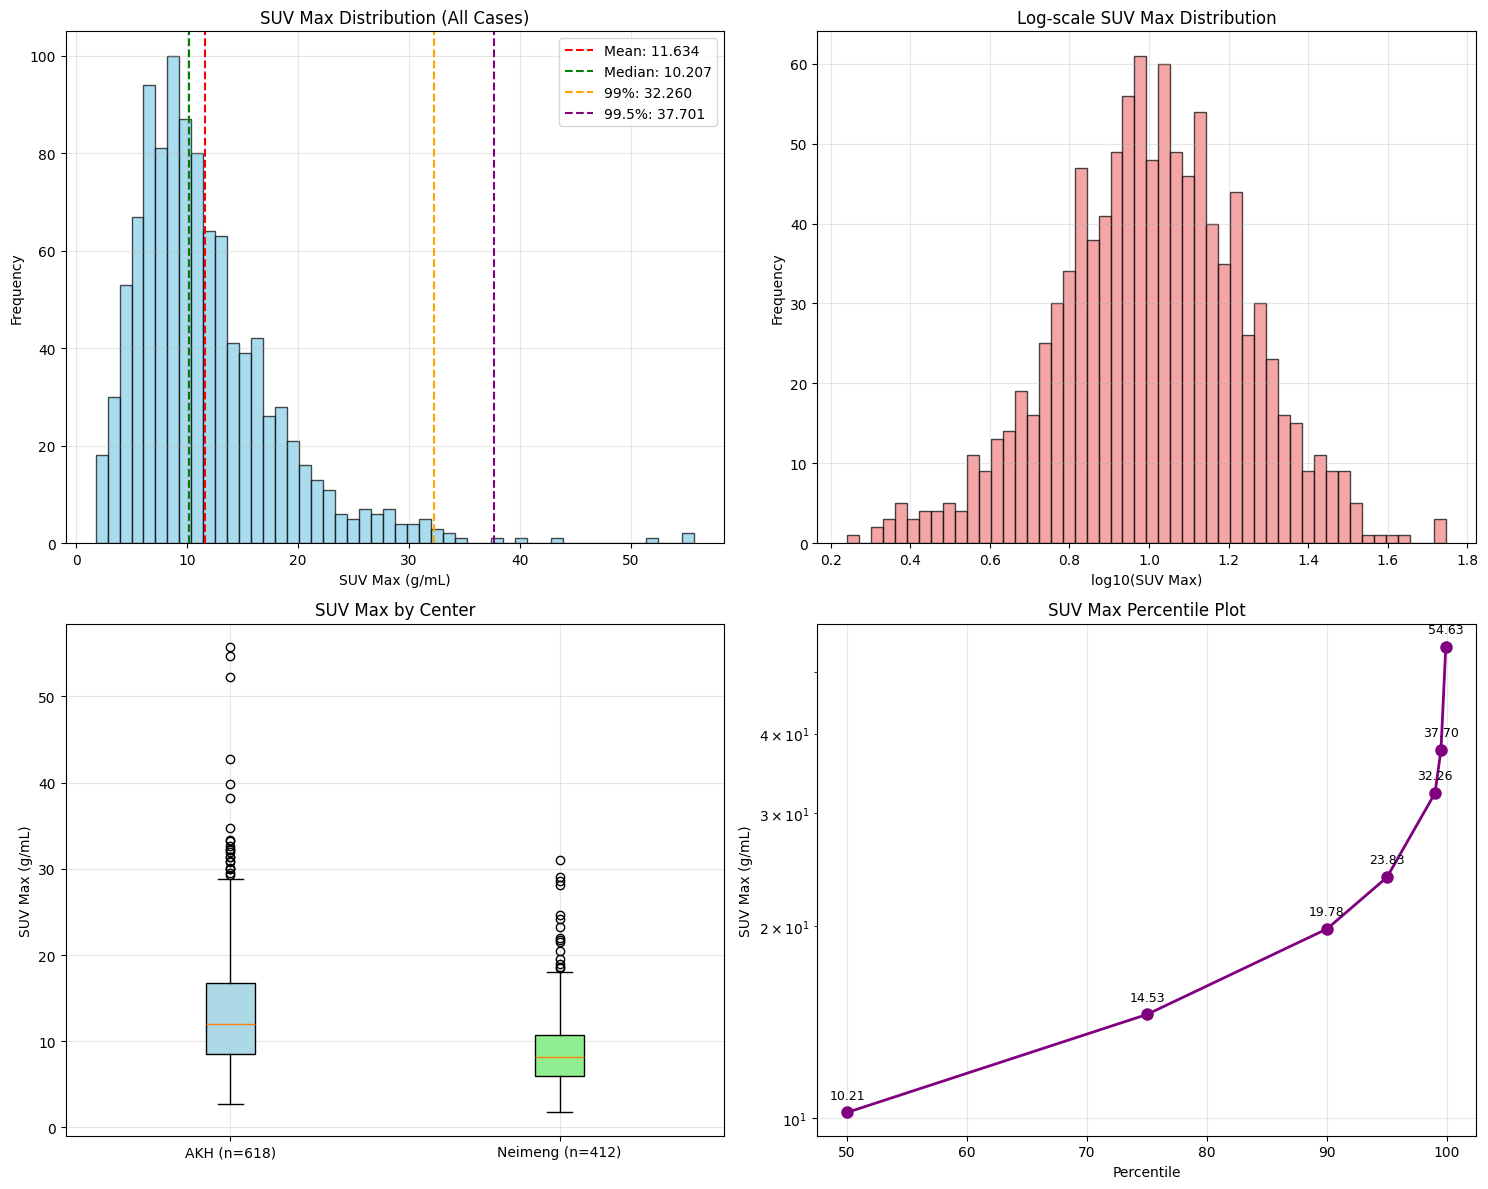

详细统计结果已保存: value_processed/report/PET-value/suv_max_statistics.txt


In [6]:
# 分析每个case的SUV max值分布
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def analyze_case_suv_max_distribution():
    """
    分析每个case的SUV max值分布，重点关注99%和99.5%分位数
    """
    # 读取SUV统计数据
    csv_path = "value_processed/report/PET-value/case_suv_statistics.csv"
    
    if not Path(csv_path).exists():
        print(f"错误: 找不到文件 {csv_path}")
        return None
    
    # 读取数据
    df = pd.read_csv(csv_path)
    print(f"成功读取数据，共 {len(df)} 个案例")
    print(f"列名: {list(df.columns)}")
    
    # 提取SUV max值
    suv_max_values = df['suv_max'].values
    
    # 计算详细统计信息
    stats = {
        'count': len(suv_max_values),
        'mean': np.mean(suv_max_values),
        'std': np.std(suv_max_values),
        'min': np.min(suv_max_values),
        'max': np.max(suv_max_values),
        'median': np.median(suv_max_values),
        'q25': np.percentile(suv_max_values, 25),
        'q75': np.percentile(suv_max_values, 75),
        'p90': np.percentile(suv_max_values, 90),
        'p95': np.percentile(suv_max_values, 95),
        'p99': np.percentile(suv_max_values, 99),
        'p99_5': np.percentile(suv_max_values, 99.5),
        'p99_9': np.percentile(suv_max_values, 99.9)
    }
    
    print(f"\n=== SUV Max 分布统计 ===")
    print(f"案例总数: {stats['count']}")
    print(f"均值: {stats['mean']:.3f} ± {stats['std']:.3f} g/mL")
    print(f"中位数: {stats['median']:.3f} g/mL")
    print(f"范围: [{stats['min']:.3f}, {stats['max']:.3f}] g/mL")
    print(f"")
    print(f"分位数信息:")
    print(f"25%分位数: {stats['q25']:.3f} g/mL")
    print(f"75%分位数: {stats['q75']:.3f} g/mL")
    print(f"90%分位数: {stats['p90']:.3f} g/mL")
    print(f"95%分位数: {stats['p95']:.3f} g/mL")
    print(f"99%分位数: {stats['p99']:.3f} g/mL")
    print(f"99.5%分位数: {stats['p99_5']:.3f} g/mL")
    print(f"99.9%分位数: {stats['p99_9']:.3f} g/mL")
    
    # 按中心分组分析
    print(f"\n=== 按中心分组分析 ===")
    center_stats = df.groupby('center')['suv_max'].agg([
        'count', 'mean', 'std', 'min', 'max', 'median',
        lambda x: np.percentile(x, 99),
        lambda x: np.percentile(x, 99.5)
    ]).round(3)
    center_stats.columns = ['count', 'mean', 'std', 'min', 'max', 'median', 'p99', 'p99_5']
    print(center_stats)
    
    # 设置matplotlib中文支持
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建可视化
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. SUV max分布直方图
    axes[0, 0].hist(suv_max_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(stats['mean'], color='red', linestyle='--', 
                      label=f'Mean: {stats["mean"]:.3f}')
    axes[0, 0].axvline(stats['median'], color='green', linestyle='--', 
                      label=f'Median: {stats["median"]:.3f}')
    axes[0, 0].axvline(stats['p99'], color='orange', linestyle='--', 
                      label=f'99%: {stats["p99"]:.3f}')
    axes[0, 0].axvline(stats['p99_5'], color='purple', linestyle='--', 
                      label=f'99.5%: {stats["p99_5"]:.3f}')
    axes[0, 0].set_xlabel('SUV Max (g/mL)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('SUV Max Distribution (All Cases)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. 对数尺度分布
    log_suv_max = np.log10(suv_max_values[suv_max_values > 0])
    axes[0, 1].hist(log_suv_max, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 1].set_xlabel('log10(SUV Max)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Log-scale SUV Max Distribution')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. 中心对比箱线图
    center_data = []
    center_labels = []
    for center in df['center'].unique():
        center_suv = df[df['center'] == center]['suv_max'].values
        center_data.append(center_suv)
        center_labels.append(f'{center} (n={len(center_suv)})')
    
    bp = axes[1, 0].boxplot(center_data, labels=center_labels, patch_artist=True)
    colors = ['lightblue', 'lightgreen']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
    axes[1, 0].set_ylabel('SUV Max (g/mL)')
    axes[1, 0].set_title('SUV Max by Center')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. 百分位数图
    percentiles = [50, 75, 90, 95, 99, 99.5, 99.9]
    p_values = [np.percentile(suv_max_values, p) for p in percentiles]
    
    axes[1, 1].plot(percentiles, p_values, 'o-', color='purple', linewidth=2, markersize=8)
    for i, (p, v) in enumerate(zip(percentiles, p_values)):
        axes[1, 1].annotate(f'{v:.2f}', (p, v), textcoords="offset points", 
                           xytext=(0,10), ha='center', fontsize=9)
    axes[1, 1].set_xlabel('Percentile')
    axes[1, 1].set_ylabel('SUV Max (g/mL)')
    axes[1, 1].set_title('SUV Max Percentile Plot')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_yscale('log')
    
    plt.tight_layout()
    
    # 保存图表
    output_dir = Path("value_processed/report/PET-value")
    output_dir.mkdir(parents=True, exist_ok=True)
    plot_file = output_dir / "suv_max_distribution_analysis.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"\n分析图表已保存: {plot_file}")
    plt.show()
    
    # 保存详细统计结果
    stats_file = output_dir / "suv_max_statistics.txt"
    with open(stats_file, 'w', encoding='utf-8') as f:
        f.write("SUV Max 分布统计分析\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"总案例数: {stats['count']}\n")
        f.write(f"均值: {stats['mean']:.6f} g/mL\n")
        f.write(f"标准差: {stats['std']:.6f} g/mL\n")
        f.write(f"最小值: {stats['min']:.6f} g/mL\n")
        f.write(f"最大值: {stats['max']:.6f} g/mL\n")
        f.write(f"中位数: {stats['median']:.6f} g/mL\n\n")
        
        f.write("关键分位数:\n")
        f.write(f"25%分位数: {stats['q25']:.6f} g/mL\n")
        f.write(f"75%分位数: {stats['q75']:.6f} g/mL\n")
        f.write(f"90%分位数: {stats['p90']:.6f} g/mL\n")
        f.write(f"95%分位数: {stats['p95']:.6f} g/mL\n")
        f.write(f"99%分位数: {stats['p99']:.6f} g/mL\n")
        f.write(f"99.5%分位数: {stats['p99_5']:.6f} g/mL\n")
        f.write(f"99.9%分位数: {stats['p99_9']:.6f} g/mL\n\n")
        
        f.write("按中心分组统计:\n")
        f.write(center_stats.to_string())
    
    print(f"详细统计结果已保存: {stats_file}")
    
    # 返回结果
    return {
        'global_stats': stats,
        'center_stats': center_stats,
        'data': df
    }

# 执行分析
print("开始分析SUV Max分布...")
suv_max_analysis = analyze_case_suv_max_distribution()

In [7]:
# PET SUV归一化和数据整理
import os
import shutil
import nibabel as nib
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import json

def normalize_pet_suv_and_organize_data():
    """
    对PET SUV值进行0-30 clip和0-1归一化，并整理所有处理后的数据
    """
    # 定义路径
    cropped_dir = "cropped_roi_96x64x128"
    ct_processed_dir = "value_processed/processed_ct"
    pet_suv_dir = "value_processed/pet_suv_converted" 
    output_base_dir = "value_processed/data"
    
    # SUV归一化参数
    suv_clip_min = 0.0
    suv_clip_max = 30.0
    
    print(f"开始PET SUV归一化和数据整理...")
    print(f"SUV clip范围: [{suv_clip_min}, {suv_clip_max}]")
    print(f"输出目录: {output_base_dir}")
    
    # 创建输出目录
    Path(output_base_dir).mkdir(parents=True, exist_ok=True)
    
    # 统计信息
    processed_count = 0
    failed_cases = []
    
    # 遍历中心
    for center_dir in os.listdir(cropped_dir):
        if not center_dir.endswith('_nifti_425') and not center_dir.endswith('_nifti_637'):
            continue
            
        center_name = center_dir.split('_')[0]  # AKH 或 Neimeng
        center_path = os.path.join(cropped_dir, center_dir)
        
        if not os.path.isdir(center_path):
            continue
            
        print(f"\n处理中心: {center_name}")
        
        # 创建中心输出目录
        center_output_dir = os.path.join(output_base_dir, center_name)
        Path(center_output_dir).mkdir(parents=True, exist_ok=True)
        
        # 遍历案例
        case_dirs = [d for d in os.listdir(center_path) if os.path.isdir(os.path.join(center_path, d))]
        
        for case_dir in tqdm(case_dirs, desc=f"Processing {center_name}"):
            try:
                case_path = os.path.join(center_path, case_dir)
                
                # 创建案例输出目录
                case_output_dir = os.path.join(center_output_dir, case_dir)
                Path(case_output_dir).mkdir(parents=True, exist_ok=True)
                
                # 检查所需文件是否存在
                ct_processed_file = os.path.join(ct_processed_dir, center_dir, case_dir, "CT_processed.nii.gz")
                pet_suv_file = os.path.join(pet_suv_dir, center_dir, case_dir, "PET_SUV.nii.gz")
                lesion_mask_file = os.path.join(case_path, "lesion_mask.nii.gz")
                lung_mask_file = os.path.join(case_path, "lung_mask.nii.gz")
                
                missing_files = []
                if not os.path.exists(ct_processed_file):
                    missing_files.append("CT_processed.nii.gz")
                if not os.path.exists(pet_suv_file):
                    missing_files.append("PET_SUV.nii.gz")
                if not os.path.exists(lesion_mask_file):
                    missing_files.append("lesion_mask.nii.gz")
                if not os.path.exists(lung_mask_file):
                    missing_files.append("lung_mask.nii.gz")
                
                if missing_files:
                    failed_cases.append(f"{center_name}/{case_dir}: 缺失文件 {missing_files}")
                    continue
                
                # 1. 复制CT处理后的文件
                ct_output_file = os.path.join(case_output_dir, "CT_processed.nii.gz")
                shutil.copy2(ct_processed_file, ct_output_file)
                
                # 2. 复制PET SUV文件
                pet_suv_output_file = os.path.join(case_output_dir, "PET_SUV.nii.gz")
                shutil.copy2(pet_suv_file, pet_suv_output_file)
                
                # 3. 处理PET SUV归一化
                pet_suv_nii = nib.load(pet_suv_file)
                pet_suv_data = pet_suv_nii.get_fdata()
                
                # SUV clip和归一化
                pet_clipped = np.clip(pet_suv_data, suv_clip_min, suv_clip_max)
                pet_normalized = pet_clipped / suv_clip_max  # 归一化到0-1
                
                # 保存归一化后的PET
                pet_normalized_nii = nib.Nifti1Image(pet_normalized.astype(np.float32), 
                                                    pet_suv_nii.affine, pet_suv_nii.header)
                pet_processed_output_file = os.path.join(case_output_dir, "PET_processed.nii.gz")
                nib.save(pet_normalized_nii, pet_processed_output_file)
                
                # 4. 复制mask文件
                lesion_output_file = os.path.join(case_output_dir, "lesion_mask.nii.gz")
                lung_output_file = os.path.join(case_output_dir, "lung_mask.nii.gz")
                shutil.copy2(lesion_mask_file, lesion_output_file)
                shutil.copy2(lung_mask_file, lung_output_file)
                
                # 5. 创建info文件
                info_data = {
                    "case_info": {
                        "center": center_name,
                        "case_id": case_dir,
                        "processing_date": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
                    },
                    "ct_processing": {
                        "description": "CT images were clipped and z-score normalized based on lung foreground",
                        "clip_percentiles": "0.5% and 99.5% of lung foreground HU values",
                        "normalization": "z-score normalization using lung foreground mean and std",
                        "output_file": "CT_processed.nii.gz"
                    },
                    "pet_suv_conversion": {
                        "description": "PET images were converted to SUV values using SUV_ratio from metadata",
                        "formula": "SUV = PET_original * SUV_ratio",
                        "output_file": "PET_SUV.nii.gz"
                    },
                    "pet_normalization": {
                        "description": "PET SUV values were clipped and normalized to 0-1 range",
                        "clip_range": f"[{suv_clip_min}, {suv_clip_max}] g/mL",
                        "normalization": f"Linear scaling: (clipped_SUV) / {suv_clip_max}",
                        "output_range": "[0, 1]",
                        "output_file": "PET_processed.nii.gz"
                    },
                    "mask_files": {
                        "lesion_mask": "lesion_mask.nii.gz - Binary mask for tumor/lesion regions",
                        "lung_mask": "lung_mask.nii.gz - Binary mask for lung regions"
                    },
                    "file_structure": {
                        "CT_processed.nii.gz": "Normalized CT image",
                        "PET_SUV.nii.gz": "SUV converted PET image", 
                        "PET_processed.nii.gz": "Normalized PET image (0-1)",
                        "lesion_mask.nii.gz": "Lesion binary mask",
                        "lung_mask.nii.gz": "Lung binary mask",
                        "info.json": "This processing information file"
                    }
                }
                
                info_file = os.path.join(case_output_dir, "info.json")
                with open(info_file, 'w', encoding='utf-8') as f:
                    json.dump(info_data, f, indent=2, ensure_ascii=False)
                
                processed_count += 1
                
            except Exception as e:
                failed_cases.append(f"{center_name}/{case_dir}: {str(e)}")
                continue
    
    print(f"\n=== 处理完成 ===")
    print(f"成功处理: {processed_count} 个案例")
    print(f"失败案例: {len(failed_cases)} 个")
    print(f"输出目录: {os.path.abspath(output_base_dir)}")
    
    # 保存处理摘要
    summary_data = {
        "processing_summary": {
            "total_processed": processed_count,
            "total_failed": len(failed_cases),
            "suv_normalization": {
                "clip_range": [suv_clip_min, suv_clip_max],
                "output_range": [0, 1]
            },
            "failed_cases": failed_cases[:50] if len(failed_cases) > 50 else failed_cases
        }
    }
    
    summary_file = os.path.join(output_base_dir, "processing_summary.json")
    with open(summary_file, 'w', encoding='utf-8') as f:
        json.dump(summary_data, f, indent=2, ensure_ascii=False)
    
    if failed_cases:
        print(f"\n部分失败案例:")
        for case in failed_cases[:10]:
            print(f"- {case}")
        if len(failed_cases) > 10:
            print(f"... 还有 {len(failed_cases)-10} 个失败案例，详情见 {summary_file}")
    
    return processed_count, failed_cases

def verify_organized_data():
    """
    验证整理后的数据结构
    """
    output_dir = "value_processed/data"
    
    if not os.path.exists(output_dir):
        print(f"输出目录不存在: {output_dir}")
        return
    
    print(f"\n=== 验证数据结构 ===")
    
    total_cases = 0
    center_stats = {}
    
    for center in os.listdir(output_dir):
        center_path = os.path.join(output_dir, center)
        if not os.path.isdir(center_path):
            continue
            
        cases = [d for d in os.listdir(center_path) if os.path.isdir(os.path.join(center_path, d))]
        center_stats[center] = len(cases)
        total_cases += len(cases)
        
        print(f"中心 {center}: {len(cases)} 个案例")
        
        # 检查第一个案例的文件结构
        if cases:
            sample_case = cases[0]
            sample_path = os.path.join(center_path, sample_case)
            expected_files = [
                "CT_processed.nii.gz",
                "PET_SUV.nii.gz", 
                "PET_processed.nii.gz",
                "lesion_mask.nii.gz",
                "lung_mask.nii.gz",
                "info.json"
            ]
            
            missing_files = []
            for file in expected_files:
                if not os.path.exists(os.path.join(sample_path, file)):
                    missing_files.append(file)
            
            if missing_files:
                print(f"  样本案例 {sample_case} 缺失文件: {missing_files}")
            else:
                print(f"  样本案例 {sample_case} 文件结构完整")
    
    print(f"\n总计: {total_cases} 个案例")
    print(f"中心分布: {center_stats}")

# 执行处理
print("开始PET SUV归一化和数据整理...")
processed_count, failed_list = normalize_pet_suv_and_organize_data()

# 验证结果
verify_organized_data()

开始PET SUV归一化和数据整理...
开始PET SUV归一化和数据整理...
SUV clip范围: [0.0, 30.0]
输出目录: value_processed/data

处理中心: Neimeng


Processing Neimeng: 100%|██████████| 412/412 [01:05<00:00,  6.26it/s]



处理中心: AKH


Processing AKH: 100%|██████████| 618/618 [01:04<00:00,  9.51it/s]


=== 处理完成 ===
成功处理: 1030 个案例
失败案例: 0 个
输出目录: /home/yaobo/Project/Lung_Cancer_Subtyping/value_processed/data

=== 验证数据结构 ===
中心 Neimeng: 412 个案例
  样本案例 214 文件结构完整
中心 AKH: 618 个案例
  样本案例 DEVECI-HIDAYET20231206 文件结构完整

总计: 1030 个案例
中心分布: {'Neimeng': 412, 'AKH': 618}


In [8]:
# 验证PET归一化结果
import random

def validate_pet_normalization():
    """
    验证PET归一化结果的数值范围
    """
    data_dir = "value_processed/data"
    
    # 随机选择几个案例进行验证
    centers = ["AKH", "Neimeng"]
    sample_cases = []
    
    for center in centers:
        center_path = os.path.join(data_dir, center)
        if os.path.exists(center_path):
            cases = [d for d in os.listdir(center_path) if os.path.isdir(os.path.join(center_path, d))]
            sample_cases.extend([(center, case) for case in random.sample(cases, min(3, len(cases)))])
    
    print("=== PET归一化验证 ===")
    
    for center, case_id in sample_cases:
        case_path = os.path.join(data_dir, center, case_id)
        
        # 读取原始SUV和归一化后的数据
        pet_suv_file = os.path.join(case_path, "PET_SUV.nii.gz")
        pet_processed_file = os.path.join(case_path, "PET_processed.nii.gz")
        
        if os.path.exists(pet_suv_file) and os.path.exists(pet_processed_file):
            # 读取数据
            pet_suv_nii = nib.load(pet_suv_file)
            pet_suv_data = pet_suv_nii.get_fdata()
            
            pet_processed_nii = nib.load(pet_processed_file)
            pet_processed_data = pet_processed_nii.get_fdata()
            
            # 统计原始SUV数据
            suv_min = np.min(pet_suv_data)
            suv_max = np.max(pet_suv_data)
            suv_mean = np.mean(pet_suv_data)
            
            # 统计归一化数据
            processed_min = np.min(pet_processed_data)
            processed_max = np.max(pet_processed_data)
            processed_mean = np.mean(pet_processed_data)
            
            print(f"\n案例: {center}/{case_id}")
            print(f"原始SUV  - 范围: [{suv_min:.3f}, {suv_max:.3f}], 均值: {suv_mean:.3f}")
            print(f"归一化后 - 范围: [{processed_min:.3f}, {processed_max:.3f}], 均值: {processed_mean:.3f}")
            
            # 验证归一化是否正确
            expected_max = min(suv_max, 30.0) / 30.0
            if abs(processed_max - expected_max) < 0.001:
                print(f"✓ 归一化正确")
            else:
                print(f"✗ 归一化异常，期望最大值: {expected_max:.3f}")

# 验证处理摘要
def check_processing_summary():
    """
    检查处理摘要文件
    """
    summary_file = "value_processed/data/processing_summary.json"
    
    if os.path.exists(summary_file):
        with open(summary_file, 'r', encoding='utf-8') as f:
            summary = json.load(f)
        
        print(f"\n=== 处理摘要 ===")
        print(f"成功处理: {summary['processing_summary']['total_processed']} 个案例")
        print(f"处理失败: {summary['processing_summary']['total_failed']} 个案例")
        print(f"SUV归一化参数:")
        print(f"  - Clip范围: {summary['processing_summary']['suv_normalization']['clip_range']}")
        print(f"  - 输出范围: {summary['processing_summary']['suv_normalization']['output_range']}")
        
        if summary['processing_summary']['total_failed'] > 0:
            print(f"\n失败案例示例:")
            for case in summary['processing_summary']['failed_cases'][:5]:
                print(f"  - {case}")

# 执行验证
validate_pet_normalization()
check_processing_summary()

print("\n=== 最终数据结构 ===")
print("数据存储在: value_processed/data/")
print("目录结构:")
print("├── AKH/")
print("│   ├── case_id_1/")
print("│   │   ├── CT_processed.nii.gz      # Z-score归一化的CT")
print("│   │   ├── PET_SUV.nii.gz           # SUV转换后的PET")
print("│   │   ├── PET_processed.nii.gz     # 0-1归一化的PET")
print("│   │   ├── lesion_mask.nii.gz       # 病灶掩膜")
print("│   │   ├── lung_mask.nii.gz         # 肺部掩膜")
print("│   │   └── info.json                # 处理信息说明")
print("│   └── ...")
print("├── Neimeng/")
print("│   └── ...")
print("└── processing_summary.json          # 整体处理摘要")

=== PET归一化验证 ===

案例: AKH/RIGELE-DEGEN-MARGIT20180730
原始SUV  - 范围: [0.000, 23.063], 均值: 0.479
归一化后 - 范围: [0.000, 0.769], 均值: 0.016
✓ 归一化正确

案例: AKH/COLAKOV-MARA20110324
原始SUV  - 范围: [0.000, 26.504], 均值: 1.016
归一化后 - 范围: [0.000, 0.883], 均值: 0.034
✓ 归一化正确

案例: AKH/GRUBHOFER-ELISABETH20221229
原始SUV  - 范围: [0.000, 16.521], 均值: 0.478
归一化后 - 范围: [0.000, 0.551], 均值: 0.016
✓ 归一化正确

案例: Neimeng/205
原始SUV  - 范围: [0.000, 13.285], 均值: 0.410
归一化后 - 范围: [0.000, 0.443], 均值: 0.014
✓ 归一化正确

案例: Neimeng/100
原始SUV  - 范围: [0.000, 9.753], 均值: 0.417
归一化后 - 范围: [0.000, 0.325], 均值: 0.014
✓ 归一化正确

案例: Neimeng/119
原始SUV  - 范围: [0.000, 16.535], 均值: 0.448
归一化后 - 范围: [0.000, 0.551], 均值: 0.015
✓ 归一化正确

=== 处理摘要 ===
成功处理: 1030 个案例
处理失败: 0 个案例
SUV归一化参数:
  - Clip范围: [0.0, 30.0]
  - 输出范围: [0, 1]

=== 最终数据结构 ===
数据存储在: value_processed/data/
目录结构:
├── AKH/
│   ├── case_id_1/
│   │   ├── CT_processed.nii.gz      # Z-score归一化的CT
│   │   ├── PET_SUV.nii.gz           # SUV转换后的PET
│   │   ├── PET_processed.nii.gz     # 0-1归一化